# Inaugural Project

> **Note the following:** 
> 1. This is an example of how to structure your **inaugural project**.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `inauguralproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [3]:
import numpy as np
import matplotlib.pyplot as plt


# autoreload modules when code is run. Otherwise, python will not see recent changes. 
%load_ext autoreload
%autoreload 2

In [2]:
from HouseholdSpecializationModel import HouseholdSpecializationModelClass

# Question 1

In [3]:
model = HouseholdSpecializationModelClass() 
model.solve_discrete()

namespace(LM=4.5, HM=4.5, LF=4.5, HF=4.5)

**Explain how you solve the model**

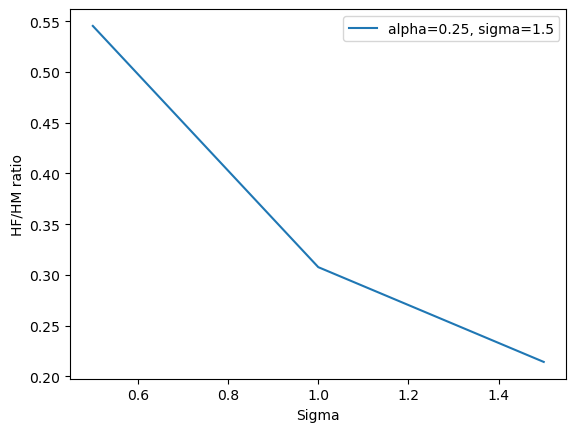

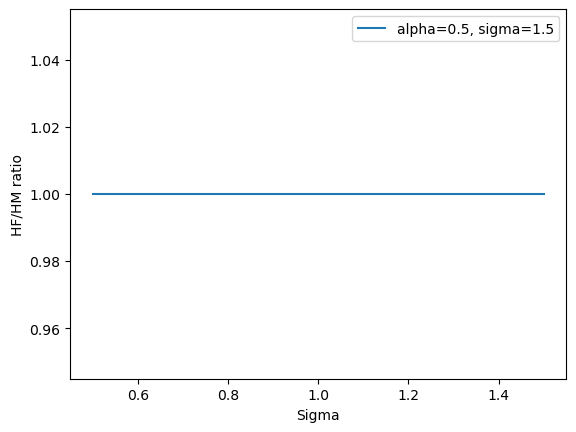

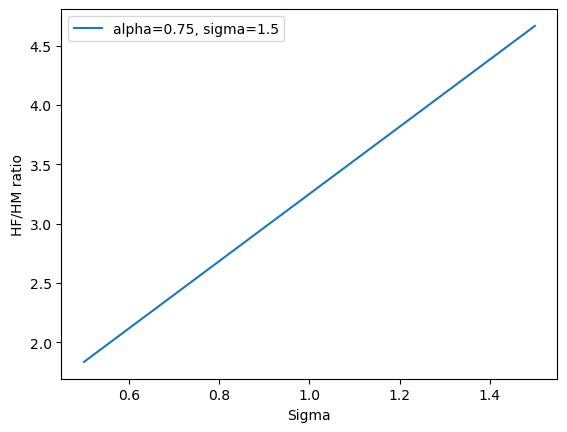

In [4]:

#parameters to loop over
# Loop over values of alpha and sigma
alpha_values = [0.25, 0.5, 0.75]
sigma_values = [0.5, 1.0, 1.5]


#The model with sigma=1
model= HouseholdSpecializationModelClass()

# Define grid of values for HM
HM_vals = np.linspace(0, 24, 48)

# Loop over values of alpha and sigma
for alpha in alpha_values:
    ratios = []
    for sigma in sigma_values:
        # Update parameters
        model.par.alpha=alpha
        model.par.sigma = sigma
        # Solve model for given parameters
        opt = model.solve_discrete()
        # Ratio HF/HM for each value of HM
        ratios.append(opt.HF / opt.HM)
        # Plot results
        label=f"alpha={alpha}, sigma={sigma}"
    plt.plot(sigma_values,ratios,label=label)
    plt.xlabel('Sigma')
    plt.ylabel('HF/HM ratio')
    plt.legend()
    plt.show()
       



# Question 2

Explain your code and procedure

[0.8, 0.9, 1.0, 1.1, 1.2]


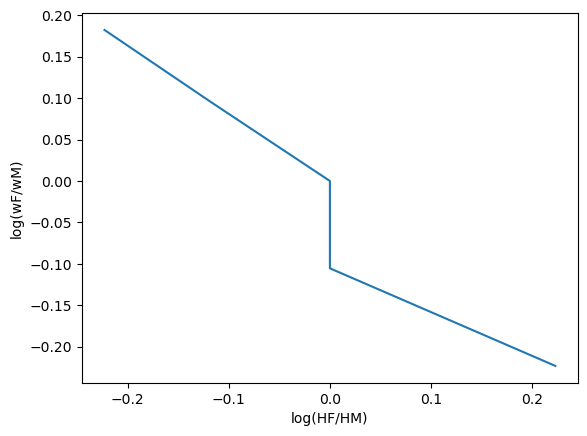

In [5]:

# Varying parameters
wF_values = [0.8, 0.9, 1.0, 1.1, 1.2]

#compute the values of HF/HM for each value of wF
model= HouseholdSpecializationModelClass()
HF_HM_values=[]
for wF in wF_values:
    model.par.wF = wF
    sol= model.solve_discrete()
    HF_HM=sol.HF/sol.HM
    HF_HM_values.append(np.log(HF_HM))


# Plot results
print(wF_values)
plt.plot(HF_HM_values,np.log(wF_values))
plt.xlabel("log(HF/HM)")
plt.ylabel("log(wF/wM)")
plt.show()


# Question 3

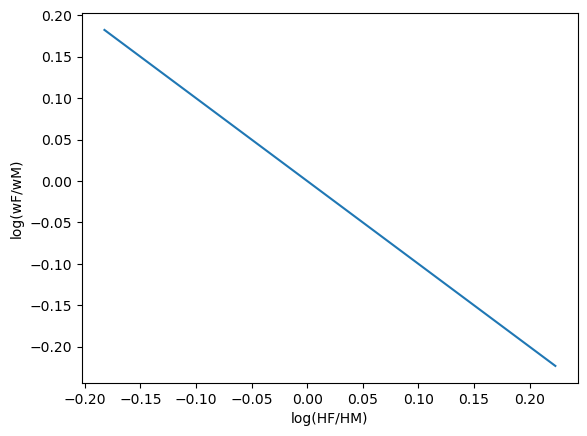

In [20]:
model3 = HouseholdSpecializationModelClass() 
model3.solve()


model3.solve_wF_vec()

#plot vector

plt.plot( np.log(model3.sol.HF_vec / model3.sol.HM_vec) , np.log(model3.par.wF_vec) ) 
plt.xlabel("log(HF/HM)")
plt.ylabel("log(wF/wM)")
plt.show()

In [10]:
model.par.wF_vec

array([0.8, 0.9, 1. , 1.1, 1.2])

# Question 4

Explain your code and procedure

In [36]:
#Estimating alpha and sigma using the continously solved model
model.estimate(mode='normal', do_print=True)

#Settting alpha and sigma to the estimated values
#model.par.alpha = model.opt.alpha
#model.par.sigma = model.opt.sigma

α_opt = 0.9820154947
σ_opt = 0.0999973324
Residual_opt = 0.000000


In [40]:
model.sol.beta1

-0.10000003943587657

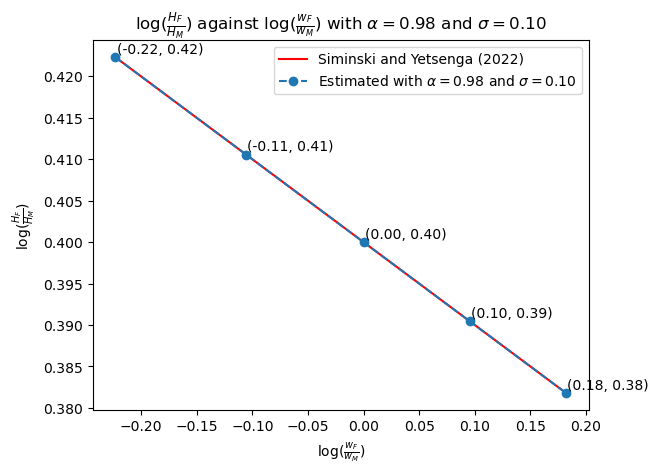

In [42]:
#Solving continously for HF/HM ratio and creating log of wFwM ratio
model.solve_wF_vec()

#Store results
logHFHM_ratio_continous = np.log( model.sol.HF_vec / model.sol.HM_vec )
logwFwM_ratio = np.log(model.par.wF_vec)

#Generating line by estimates from Siminski and Yetsenga (2022)
x = np.log(np.linspace(0.8, 1.2, 2))
y = model.par.beta0_target + model.par.beta1_target*x

#Plot results in a plot
plt.plot(x, y, color = 'red', linestyle = '-', label='Siminski and Yetsenga (2022)')
plt.plot(logwFwM_ratio, logHFHM_ratio_continous, 
         marker = 'o', 
         linestyle = '--', 
         label = 'Estimated with '+ r'$\alpha=$' f'{model.par.alpha:.2f}'+ " and " + r'$\sigma=$' f'{model.par.sigma:.2f}')

plt.legend(loc='upper right')

#Set title
plt.title(r'$\log(\frac{H_F}{H_M})$' + " against " r'$\log(\frac{w_F}{w_M})$' + " with " + r'$\alpha=$' f'{model.par.alpha:.2f}'+ " and " + r'$\sigma=$' f'{model.par.sigma:.2f}')

#Set labels
plt.xlabel(r'$\log(\frac{w_F}{w_M})$')
plt.ylabel(r'$\log(\frac{H_F}{H_M})$')

#Looping over data to create annotations
for i in range(5):
    plt.annotate(f"({logwFwM_ratio[i]:.2f}, {logHFHM_ratio_continous[i]:.2f})", (logwFwM_ratio[i]+0.001, logHFHM_ratio_continous[i]+0.0005))

#Show plot
plt.show()

# Question 5

In [1]:
from HouseholdSpecializationModel import HouseholdSpecializationModelClassExtended

from scipy import optimize

modelext = HouseholdSpecializationModelClassExtended()


def obje(x):
    modelext.par.alpha=x[0]
    modelext.par.sigma=x[1]
    modelext.solve_wF_vec()
    modelext.run_regression()
    return (modelext.par.beta0_target - modelext.sol.beta0)**2 + (modelext.par.beta1_target - modelext.sol.beta1)**2

bounds = [(0.5,0.99),(0.01, 0.3)]
initial_guess = [0.8, 0.1]
#initial guess og bounds er vigtige. Bounds fra en 0.5 til 0.9
resext = optimize.minimize(obje, initial_guess, method='Nelder-Mead', bounds=bounds, tol = 0.000000001)

print(resext)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 7.813149800407115e-16
             x: [ 9.820e-01  9.999e-02]
           nit: 66
          nfev: 141
 final_simplex: (array([[ 9.820e-01,  9.999e-02],
                       [ 9.820e-01,  9.999e-02],
                       [ 9.820e-01,  9.999e-02]]), array([ 7.813e-16,  1.062e-15,  5.450e-15]))


In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

modelext = HouseholdSpecializationModelClassExtended()


alpha_vals = np.linspace(0.5, 0.9, 10)  # define range of alpha values to test
sigma_vals = np.linspace(0.1, 0.3, 10)  # define range of sigma values to test

errors = np.zeros((len(alpha_vals), len(sigma_vals)))  # initialize array to hold errors

for i, alpha in enumerate(alpha_vals):
    for j, sigma in enumerate(sigma_vals):
        modelext.par.alpha = 0.5
        modelext.par.sigma = sigma
        modelext.solve_wF_vec(discrete=False)
        modelext.run_regression()
        errors[i,j] = (modelext.par.beta0_target - modelext.sol.beta0)**2 + (modelext.par.beta1_target - modelext.sol.beta1)**2

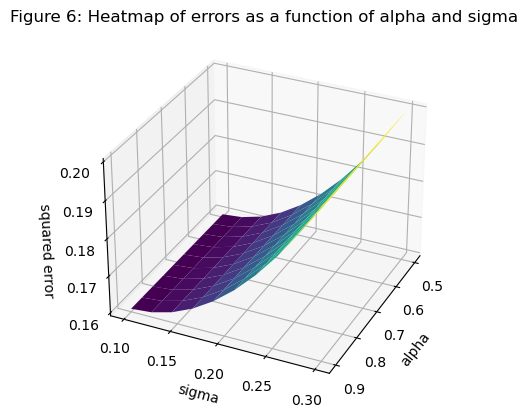

In [6]:
# create 3D plot of squared errors as a function of alpha and sigma
alpha_mesh, sigma_mesh = np.meshgrid(alpha_vals, sigma_vals, indexing='ij')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(alpha_mesh, sigma_mesh, errors, cmap='viridis')
ax.set_xlabel('alpha')
ax.set_ylabel('sigma')
ax.set_zlabel('squared error')
ax.set_title("Figure 6: Heatmap of errors as a function of alpha and sigma")

ax.view_init(elev=30, azim=25)  # adjust view angle
plt.show()